In [1]:
%matplotlib inline
import os,sys
import numpy as np
import imgaug as ia
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split

In [3]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

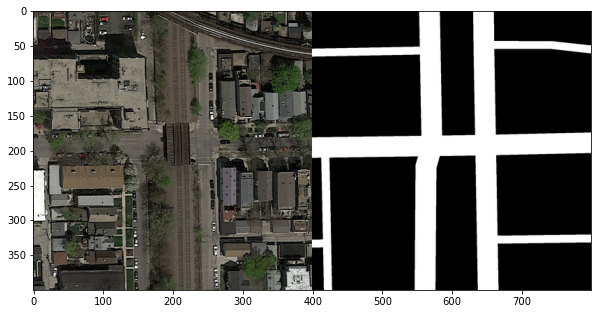

In [4]:
root_dir = "data/training/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"

files = os.listdir(image_dir)
n = len(files)

# Loaded a set of images
imgs = [load_image(image_dir + files[i]) for i in range(n)]
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

fig1 = plt.figure(figsize=(10, 10))
plt.imshow(concatenate_images(imgs[0], gt_imgs[0]))

In [5]:
# Data augmentation by rotating all images/masks and randomly flipping them 
images = [img for img in imgs] 
masks = [msk for msk in gt_imgs] 

rotations = [(0, 45), (45, 90), (90, 135), (135, 180), (0, -45), (-45, -90), (-90, -135), (-135, -180)]

for rot in rotations:
    seq = iaa.Sequential([
        iaa.Rotate(rot), 
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5)
    ], random_order=True)
    seq = seq.to_deterministic()
    
    images += seq(images=imgs)
    masks += seq(images=gt_imgs)

In [6]:
images_tr, images_te, masks_tr, masks_te = train_test_split(images, masks, test_size=0.2, random_state=42)

In [7]:
# Extract patches from input images
patch_size = 100 # each patch is 16*16 pixels

images_tr = [img_crop(img, patch_size, patch_size) for img in images_tr]
masks_tr = [img_crop(msk, patch_size, patch_size) for msk in masks_tr]

# Linearize list of patches
images_tr = np.asarray([images_tr[i][j] for i in range(len(images_tr)) for j in range(len(images_tr[i]))])
masks_tr =  np.asarray([masks_tr[i][j] for i in range(len(masks_tr)) for j in range(len(masks_tr[i]))])